# Model Analysis
File to test and tune models

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import json

## Pre-requisites 
Loading data and declaring functions for visualising model perfrmance 

In [3]:
# Data Loading
def load_pca_data(split_dir):
    X = np.load(os.path.join(split_dir, 'X_pca.npy'))
    y = np.load(os.path.join(split_dir, 'y.npy'))
    return X, y

def load_config(config_path):
    """
    Load config parameters (data paths, etc.) from JSON file.
    Args:
        config_path (str): Where to read config file.
    Returns:
        config (dict): Dictionary of config parameters.
    """
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

In [4]:
# Data Loading
def load_data(split_dir):
    X = np.load(os.path.join(split_dir, 'X.npy'))
    y = np.load(os.path.join(split_dir, 'y.npy'))
    return X, y

def load_config(config_path):
    """
    Load config parameters (data paths, etc.) from JSON file.
    Args:
        config_path (str): Where to read config file.
    Returns:
        config (dict): Dictionary of config parameters.
    """
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

In [5]:
config = load_config("../config.json")
data_root = config["processed_data_dir"]
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')
test_dir = os.path.join(data_root, 'test')

X_train, y_train = load_pca_data(train_dir)
X_val, y_val = load_pca_data(val_dir)
X_test, y_test = load_pca_data(test_dir)

In [6]:
def evaluate_model(clf, X, y, set_name="Validation"):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1] if len(clf.classes_) == 2 else clf.predict_proba(X)
    acc = accuracy_score(y, y_pred)
    print(f"{set_name} Accuracy: {acc:.3f}")
    print(f"{set_name} Classification Report:\n", classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return y_pred, y_prob

In [7]:
def plot_roc_curve(y, y_prob, set_name="Validation"):
    if len(np.unique(y)) == 2:
        fpr, tpr, thresholds = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{set_name} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
        print(f"{set_name} ROC AUC: {roc_auc:.3f}")

In [8]:
def plot_precision_recall(y_true, y_scores, class_names=None):
    """
    Plots precision-recall curves for each class.
    Args:
        y_true (array-like): True labels (N,)
        y_scores (array-like): Shape (N, n_classes) predicted probabilities
        class_names (list): List of class names for legend
    """
    n_classes = y_scores.shape[1]
    plt.figure()
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve((y_true == i).astype(int), y_scores[:, i])
        ap = average_precision_score((y_true == i).astype(int), y_scores[:, i])
        label = f"Class {i}" if class_names is None else class_names[i]
        plt.plot(recall, precision, lw=2, label=f'{label} (AP={ap:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Logistic Regression

In [9]:
def train_logistic_regression(X_train, y_train):
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    return clf

Validation Results:
Validation Accuracy: 0.754
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81        66
           1       0.59      0.53      0.56        32
           2       0.86      0.90      0.88        20

    accuracy                           0.75       118
   macro avg       0.75      0.75      0.75       118
weighted avg       0.75      0.75      0.75       118



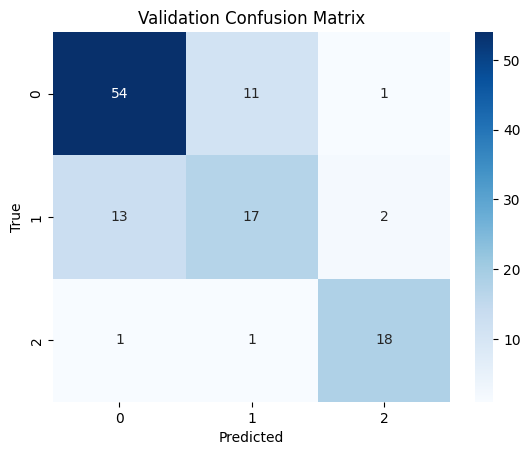

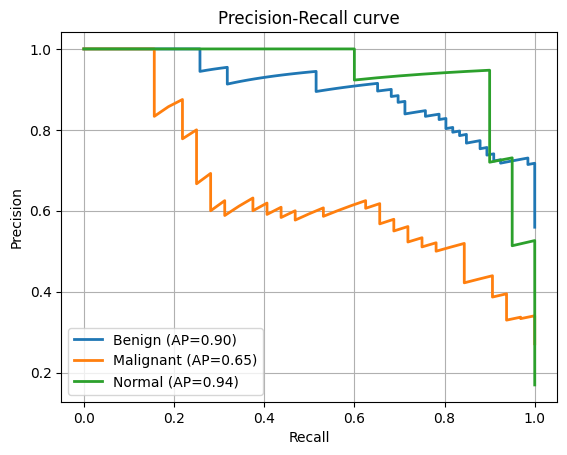

Test Results:
Test Accuracy: 0.812
Test Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87        66
           1       0.68      0.55      0.61        31
           2       0.90      0.90      0.90        20

    accuracy                           0.81       117
   macro avg       0.80      0.79      0.79       117
weighted avg       0.80      0.81      0.81       117



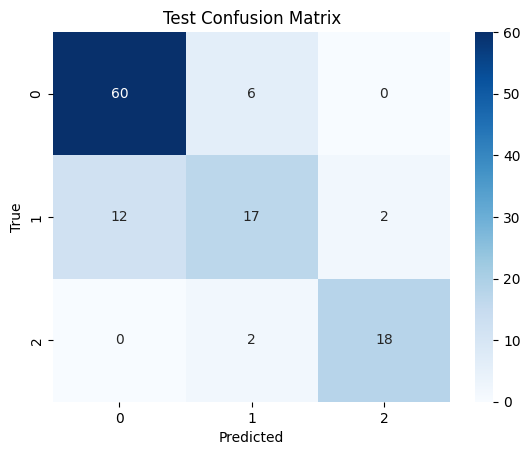

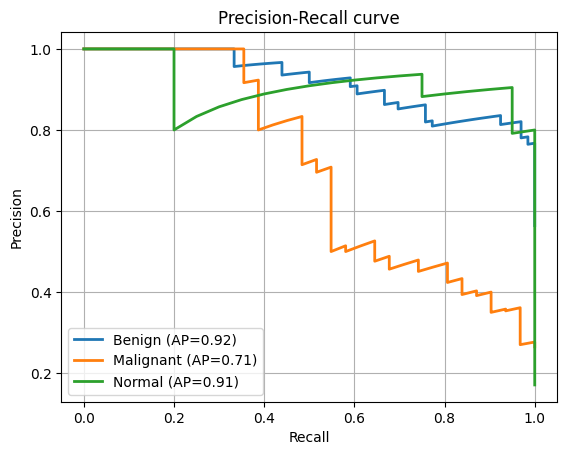

In [10]:

class_names = ["Benign", "Malignant", "Normal"]
clf = train_logistic_regression(X_train, y_train)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)


# k Nearest Neighbour

In [11]:
def train_knn_weighted(X_train, y_train, k=5):
    # Use weights="distance" so nearer neighbors count more
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    return knn

k=1, Cross-Validation Error: 0.2128
k=2, Cross-Validation Error: 0.2514
k=3, Cross-Validation Error: 0.2330
k=4, Cross-Validation Error: 0.2550
k=5, Cross-Validation Error: 0.2495
k=6, Cross-Validation Error: 0.2514
k=7, Cross-Validation Error: 0.2330
k=8, Cross-Validation Error: 0.2477
k=9, Cross-Validation Error: 0.2312
k=10, Cross-Validation Error: 0.2404
k=11, Cross-Validation Error: 0.2349
k=12, Cross-Validation Error: 0.2404
k=13, Cross-Validation Error: 0.2422
k=14, Cross-Validation Error: 0.2514
k=15, Cross-Validation Error: 0.2459
k=16, Cross-Validation Error: 0.2404
k=17, Cross-Validation Error: 0.2404
k=18, Cross-Validation Error: 0.2349
k=19, Cross-Validation Error: 0.2385
k=20, Cross-Validation Error: 0.2385
Best k found: 1 with error 0.2128


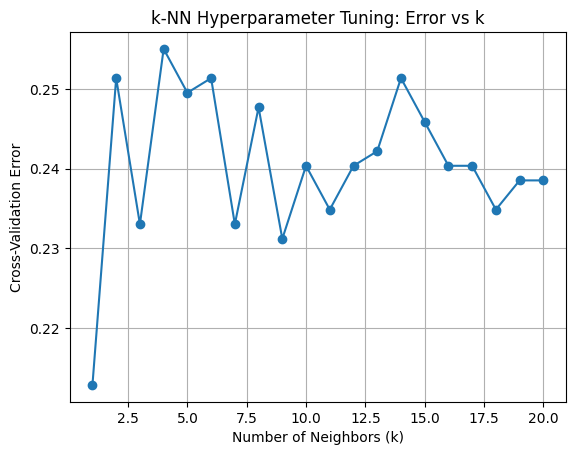

In [12]:
def knn_cross_validation(X_train, y_train, k_range=range(1, 21), cv=5):
    """
    Performs k-fold cross-validation to find the best k in k-NN
    Args:
        X_train (ndarray): Training features
        y_train (ndarray): Training labels
        k_range (iterable): Values of k to evaluate
        cv (int): Number of cross-validation folds
    Returns:
        best_k (int): Value of k with lowest error
        validation_errors (list): Average error for each k
    """
    validation_errors = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        # Use cross_val_score with accuracy scoring
        scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='accuracy')
        avg_error = 1 - scores.mean()  # error = 1 - accuracy
        validation_errors.append(avg_error)
        print(f"k={k}, Cross-Validation Error: {avg_error:.4f}")

    best_k = k_range[np.argmin(validation_errors)]
    print(f"Best k found: {best_k} with error {min(validation_errors):.4f}")

    # Plot error curve
    plt.figure()
    plt.plot(k_range, validation_errors, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Cross-Validation Error')
    plt.title('k-NN Hyperparameter Tuning: Error vs k')
    plt.grid(True)
    plt.show()

    return best_k, validation_errors


best_k, errors = knn_cross_validation(X_train, y_train, k_range=range(1,21), cv=5)


Validation Results:
Validation Accuracy: 0.644
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.83      0.75        66
           1       0.40      0.31      0.35        32
           2       0.92      0.55      0.69        20

    accuracy                           0.64       118
   macro avg       0.67      0.57      0.60       118
weighted avg       0.64      0.64      0.63       118



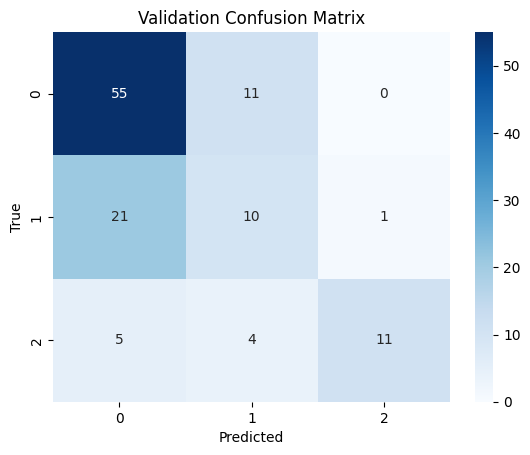

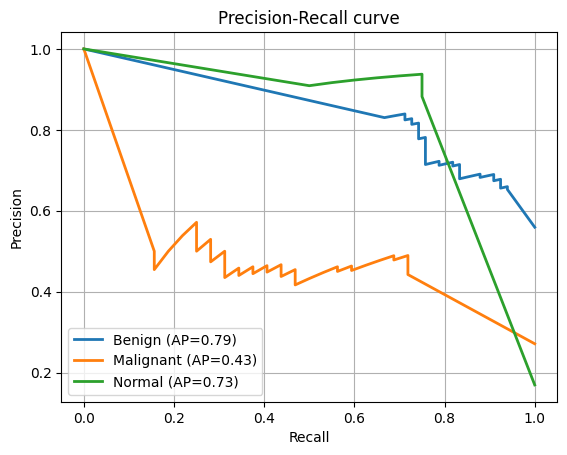

Test Results:
Test Accuracy: 0.786
Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85        66
           1       0.68      0.55      0.61        31
           2       0.93      0.70      0.80        20

    accuracy                           0.79       117
   macro avg       0.80      0.72      0.75       117
weighted avg       0.79      0.79      0.78       117



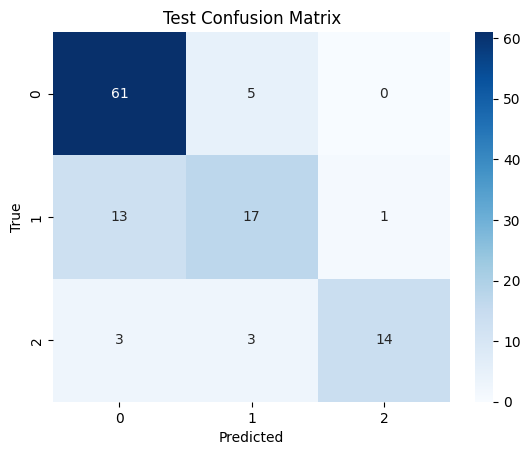

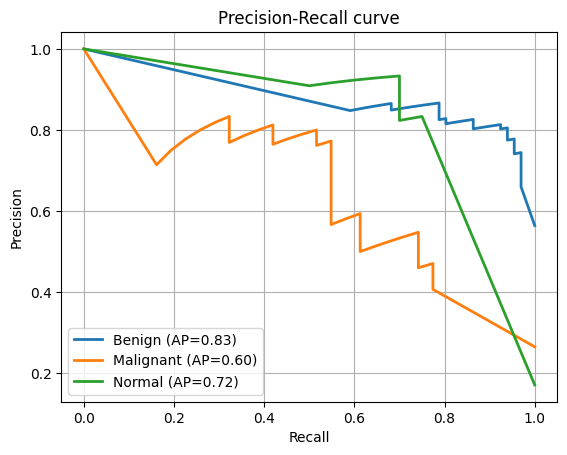

In [13]:
#Initilsie k
k = 3

knn_clf = train_knn_weighted(X_train, y_train, k=k)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(knn_clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(knn_clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)

# Support Vector Mechanism

In [14]:
def train_svm(X_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
    """
    Trains SVM with specified kernel and hyperparameters.
    multiclass is handled by one-vs-one automatically by scikit-learn's SVC.
    """
    svm = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)
    return svm

Validation Results:
Validation Accuracy: 0.780
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        66
           1       0.64      0.66      0.65        32
           2       0.81      0.85      0.83        20

    accuracy                           0.78       118
   macro avg       0.76      0.77      0.77       118
weighted avg       0.78      0.78      0.78       118



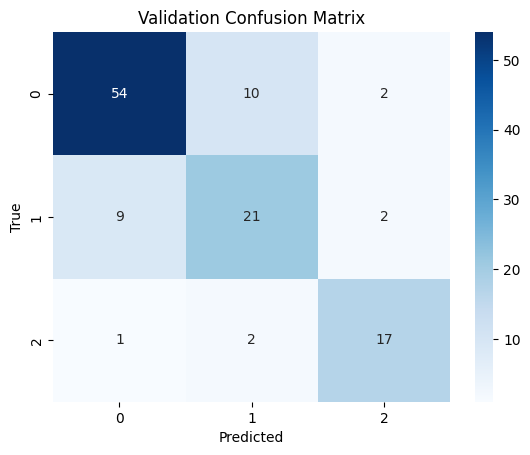

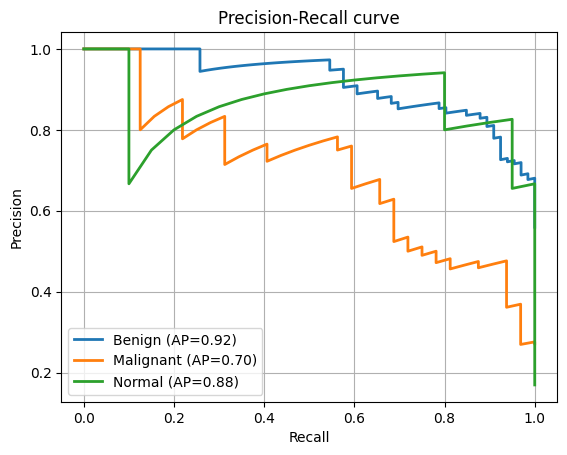

Test Results:
Test Accuracy: 0.829
Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88        66
           1       0.67      0.77      0.72        31
           2       0.82      0.90      0.86        20

    accuracy                           0.83       117
   macro avg       0.81      0.84      0.82       117
weighted avg       0.84      0.83      0.83       117



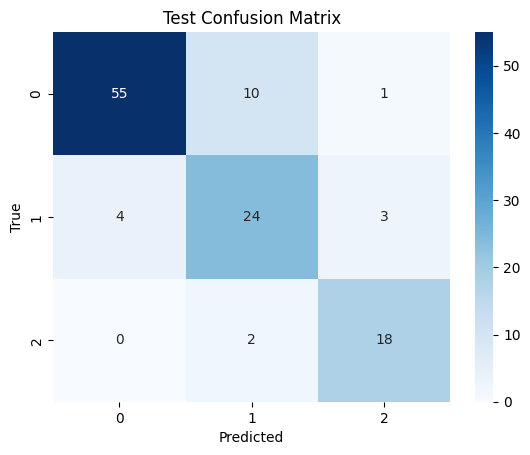

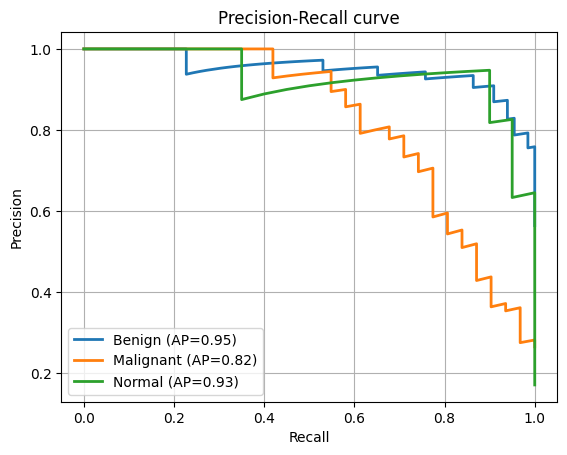

In [15]:
svm_clf = train_svm(X_train, y_train, kernel='rbf', C=1, gamma='scale')

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(svm_clf, X_val, y_val, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names=["Benign", "Malignant", "Normal"])

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(svm_clf, X_test, y_test, "Test")
plot_precision_recall(y_test, y_test_prob, class_names=["Benign", "Malignant", "Normal"])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27300
[LightGBM] [Info] Number of data points in the train set: 545, number of used features: 150
[LightGBM] [Info] Start training from score -0.580474
[LightGBM] [Info] Start training from score -1.310353
[LightGBM] [Info] Start training from score -1.768186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


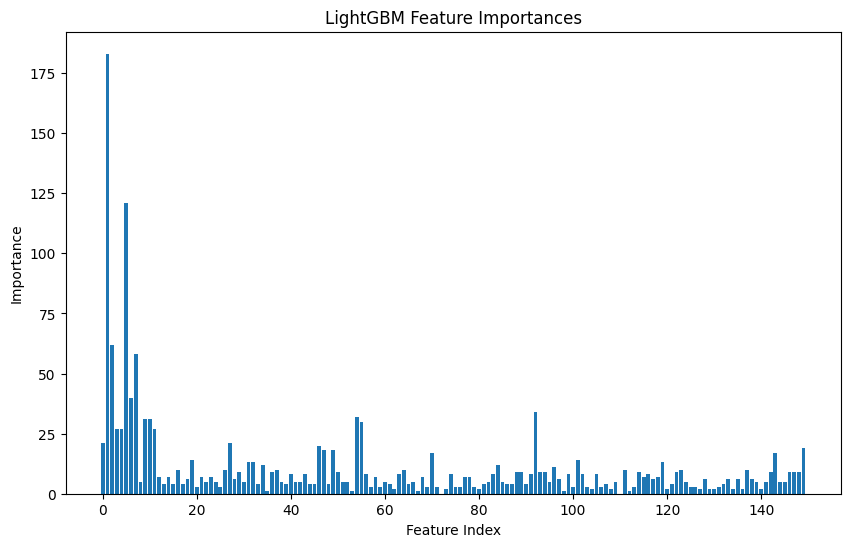

In [16]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit LightGBM classifier
lgb_clf = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42, n_estimators=100)

# Train
# lgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='multi_logloss', early_stopping_rounds=20, verbose=10)
lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(20)],
)


# Predict on test set
y_pred = lgb_clf.predict(X_test)

# Evaluate results
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# # (Optional) Save the model
# import joblib
# joblib.dump(lgb_clf, "results/lightgbm_model.pkl")

# (Optional) Feature importances
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
plt.bar(np.arange(X_train.shape[1]), lgb_clf.feature_importances_)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('LightGBM Feature Importances')
plt.show()


[0]	validation_0-mlogloss:0.89299
[1]	validation_0-mlogloss:0.78259
[2]	validation_0-mlogloss:0.71832
[3]	validation_0-mlogloss:0.65785
[4]	validation_0-mlogloss:0.63097
[5]	validation_0-mlogloss:0.60966
[6]	validation_0-mlogloss:0.60803
[7]	validation_0-mlogloss:0.59367
[8]	validation_0-mlogloss:0.59329
[9]	validation_0-mlogloss:0.59108
[10]	validation_0-mlogloss:0.59107
[11]	validation_0-mlogloss:0.59181
[12]	validation_0-mlogloss:0.60195
[13]	validation_0-mlogloss:0.60544
[14]	validation_0-mlogloss:0.61095
[15]	validation_0-mlogloss:0.62095
[16]	validation_0-mlogloss:0.62450
[17]	validation_0-mlogloss:0.62924
[18]	validation_0-mlogloss:0.63489
[19]	validation_0-mlogloss:0.64030
[20]	validation_0-mlogloss:0.65090
[21]	validation_0-mlogloss:0.65374
[22]	validation_0-mlogloss:0.65748
[23]	validation_0-mlogloss:0.66499
[24]	validation_0-mlogloss:0.67209
[25]	validation_0-mlogloss:0.67667
[26]	validation_0-mlogloss:0.67838
[27]	validation_0-mlogloss:0.68093
[28]	validation_0-mlogloss:0.6

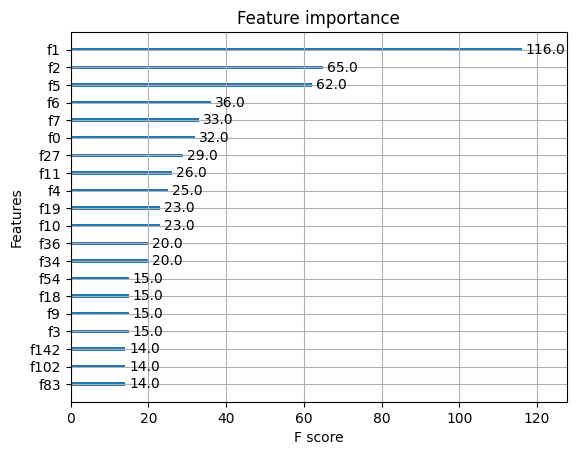

In [17]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Assume labels are already encoded as 0,1,2

# Initialize model
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    n_estimators=100,
    eval_metric='mlogloss',
    early_stopping_rounds=20
)

xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Predict
y_pred = xgb_clf.predict(X_test)

# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# # Save the model
# import joblib
# joblib.dump(xgb_clf, "results/xgboost_model.pkl")

# Plot feature importance
xgb.plot_importance(xgb_clf, max_num_features=20)
plt.show()


In [18]:
import xgboost as xgb
print(xgb.__version__)

2.1.4


# No PCA

In [19]:
config = load_config("../config.json")
data_root = config["processed_data_dir"]
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')
test_dir = os.path.join(data_root, 'test')

X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

Validation Results:
Validation Accuracy: 0.746
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80        66
           1       0.57      0.50      0.53        32
           2       0.86      0.90      0.88        20

    accuracy                           0.75       118
   macro avg       0.74      0.74      0.74       118
weighted avg       0.74      0.75      0.74       118



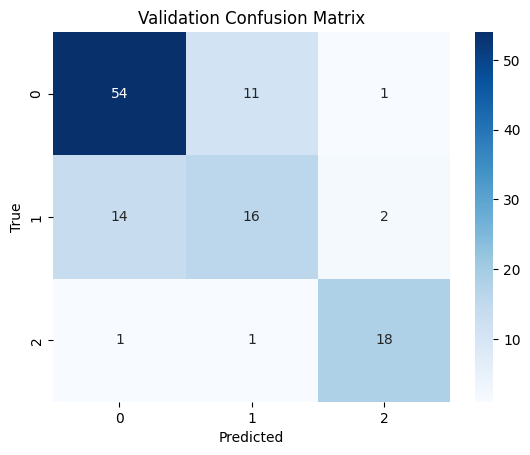

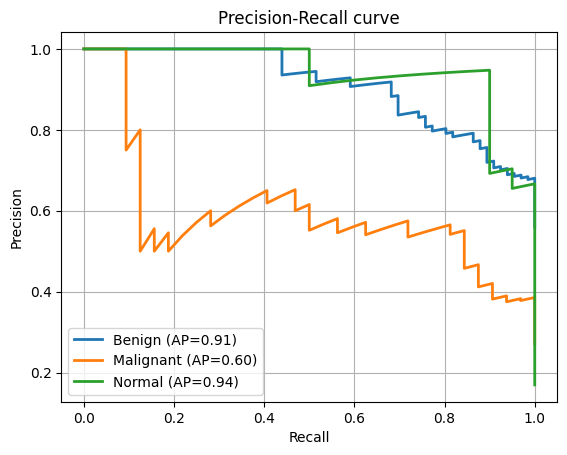

Test Results:
Test Accuracy: 0.821
Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88        66
           1       0.70      0.61      0.66        31
           2       0.89      0.85      0.87        20

    accuracy                           0.82       117
   macro avg       0.81      0.79      0.80       117
weighted avg       0.82      0.82      0.82       117



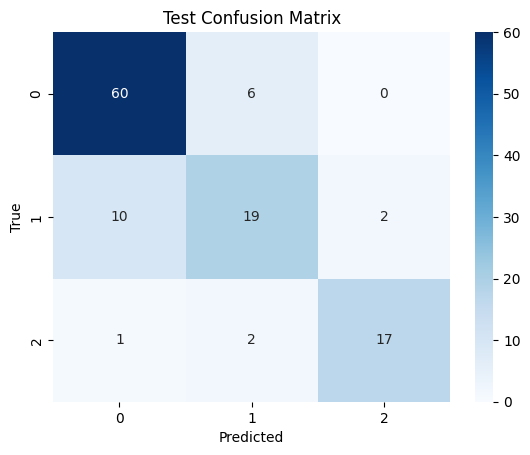

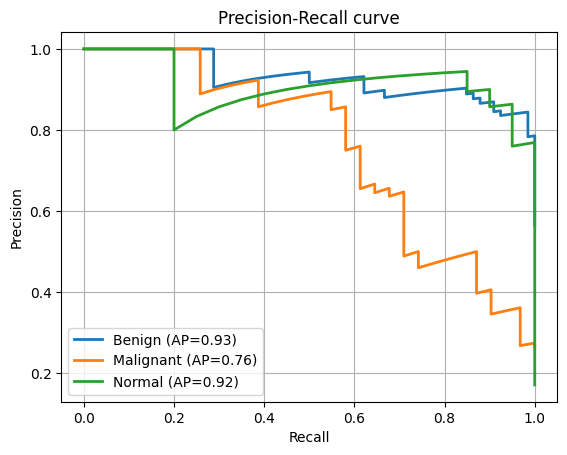

In [20]:

class_names = ["Benign", "Malignant", "Normal"]
clf = train_logistic_regression(X_train, y_train)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)


Validation Results:
Validation Accuracy: 0.644
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.83      0.74        66
           1       0.42      0.31      0.36        32
           2       0.92      0.55      0.69        20

    accuracy                           0.64       118
   macro avg       0.67      0.57      0.60       118
weighted avg       0.64      0.64      0.63       118



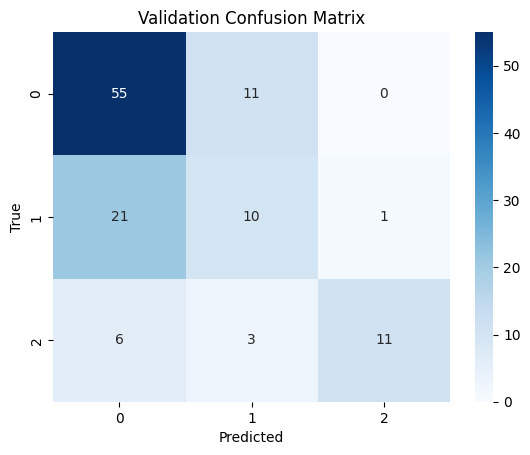

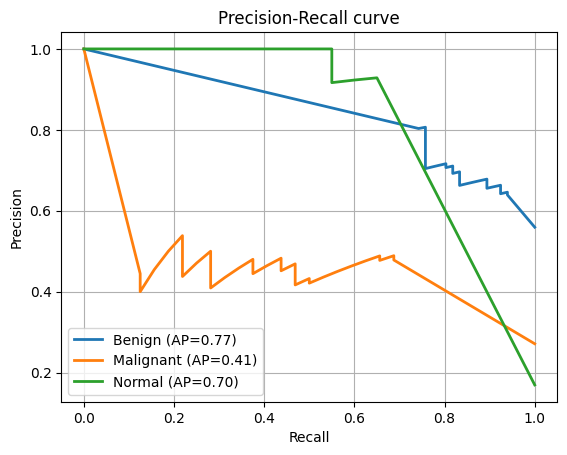

Test Results:
Test Accuracy: 0.778
Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.94      0.86        66
           1       0.67      0.52      0.58        31
           2       0.93      0.65      0.76        20

    accuracy                           0.78       117
   macro avg       0.79      0.70      0.73       117
weighted avg       0.78      0.78      0.77       117



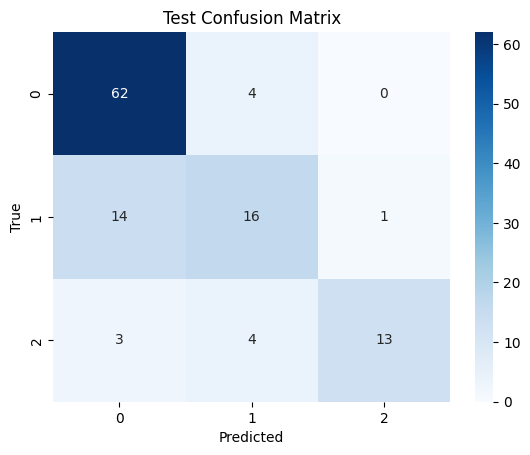

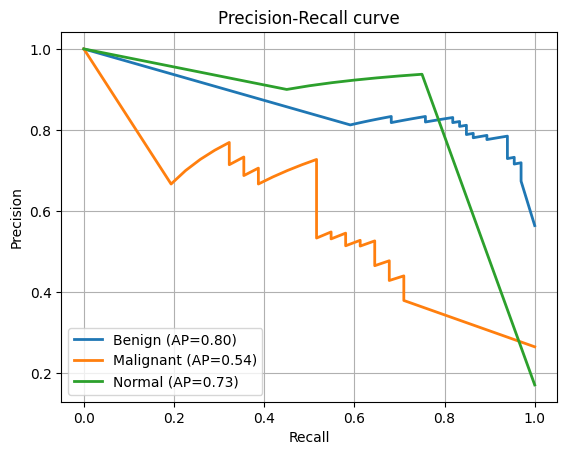

In [21]:
#Initilsie k
k = 3

knn_clf = train_knn_weighted(X_train, y_train, k=k)

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(knn_clf, X_val, y_val, "Validation")
plot_roc_curve(y_val, y_val_prob, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names)

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(knn_clf, X_test, y_test, "Test")
plot_roc_curve(y_test, y_test_prob, "Test")
plot_precision_recall(y_test, y_test_prob, class_names)

Validation Results:
Validation Accuracy: 0.771
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82        66
           1       0.62      0.66      0.64        32
           2       0.81      0.85      0.83        20

    accuracy                           0.77       118
   macro avg       0.76      0.77      0.76       118
weighted avg       0.78      0.77      0.77       118



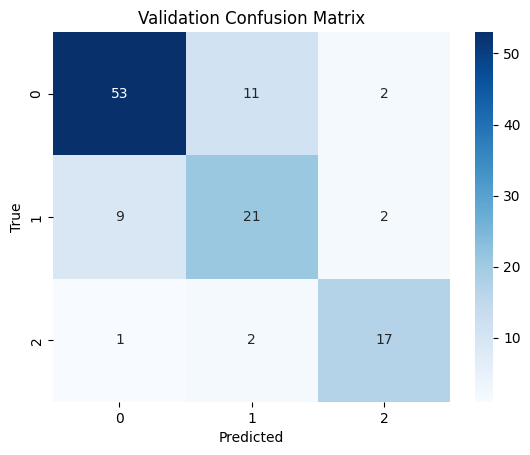

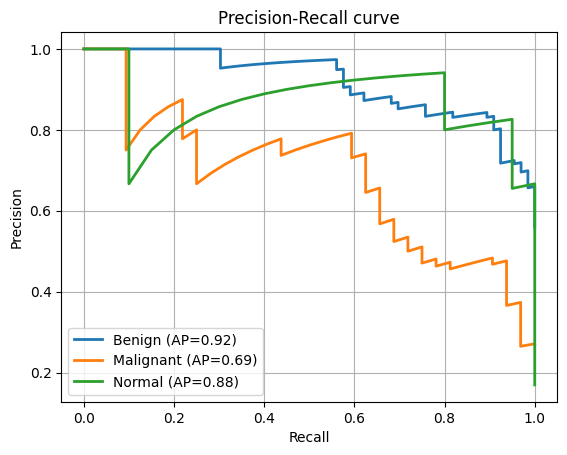

Test Results:
Test Accuracy: 0.838
Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88        66
           1       0.69      0.77      0.73        31
           2       0.83      0.95      0.88        20

    accuracy                           0.84       117
   macro avg       0.81      0.85      0.83       117
weighted avg       0.85      0.84      0.84       117



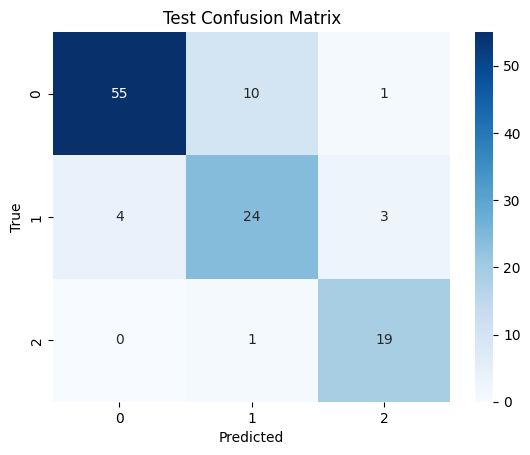

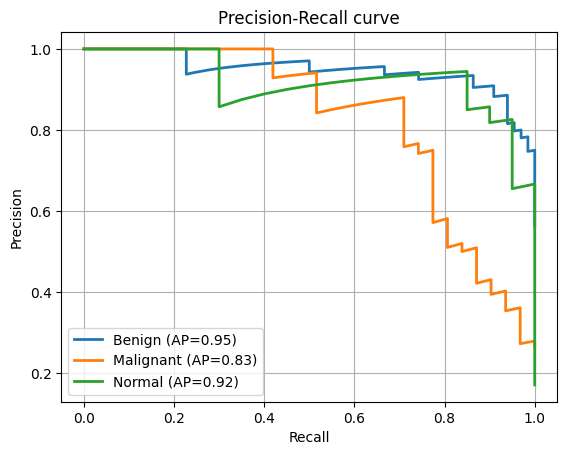

In [22]:
svm_clf = train_svm(X_train, y_train, kernel='rbf', C=1, gamma='scale')

print("Validation Results:")
y_val_pred, y_val_prob = evaluate_model(svm_clf, X_val, y_val, "Validation")
plot_precision_recall(y_val, y_val_prob, class_names=["Benign", "Malignant", "Normal"])

print("Test Results:")
y_test_pred, y_test_prob = evaluate_model(svm_clf, X_test, y_test, "Test")
plot_precision_recall(y_test, y_test_prob, class_names=["Benign", "Malignant", "Normal"])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1889777
[LightGBM] [Info] Number of data points in the train set: 545, number of used features: 16388
[LightGBM] [Info] Start training from score -0.580474
[LightGBM] [Info] Start training from score -1.310353
[LightGBM] [Info] Start training from score -1.768186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/Users/jessica/Documents/GitHub/breast_cancer_detection/venv_1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.8290598290598291
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87        66
           1       0.88      0.48      0.62        31
           2       0.90      0.95      0.93        20

    accuracy                           0.83       117
   macro avg       0.86      0.80      0.81       117
weighted avg       0.84      0.83      0.81       117

Confusion Matrix:
 [[63  2  1]
 [15 15  1]
 [ 1  0 19]]


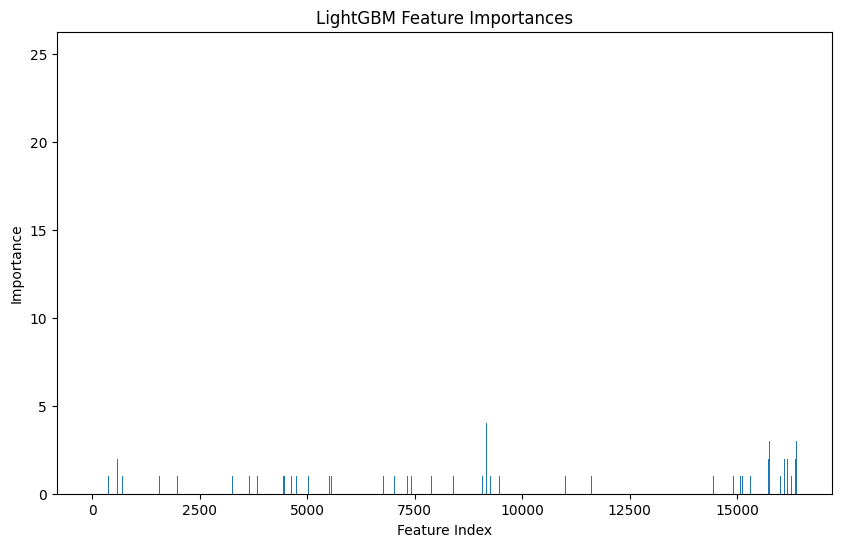

In [23]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit LightGBM classifier
lgb_clf = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42, n_estimators=100)

# Train
# lgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='multi_logloss', early_stopping_rounds=20, verbose=10)
lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(20)],
)


# Predict on test set
y_pred = lgb_clf.predict(X_test)

# Evaluate results
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# # (Optional) Save the model
# import joblib
# joblib.dump(lgb_clf, "results/lightgbm_model.pkl")

# (Optional) Feature importances
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
plt.bar(np.arange(X_train.shape[1]), lgb_clf.feature_importances_)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('LightGBM Feature Importances')
plt.show()


[0]	validation_0-mlogloss:0.91003
[1]	validation_0-mlogloss:0.80459
[2]	validation_0-mlogloss:0.73273
[3]	validation_0-mlogloss:0.68360
[4]	validation_0-mlogloss:0.63568
[5]	validation_0-mlogloss:0.61582
[6]	validation_0-mlogloss:0.59576
[7]	validation_0-mlogloss:0.57478
[8]	validation_0-mlogloss:0.55532
[9]	validation_0-mlogloss:0.54943
[10]	validation_0-mlogloss:0.55152
[11]	validation_0-mlogloss:0.55551
[12]	validation_0-mlogloss:0.56198
[13]	validation_0-mlogloss:0.56785
[14]	validation_0-mlogloss:0.56779
[15]	validation_0-mlogloss:0.57278
[16]	validation_0-mlogloss:0.58045
[17]	validation_0-mlogloss:0.58515
[18]	validation_0-mlogloss:0.58774
[19]	validation_0-mlogloss:0.59265
[20]	validation_0-mlogloss:0.59324
[21]	validation_0-mlogloss:0.59927
[22]	validation_0-mlogloss:0.59912
[23]	validation_0-mlogloss:0.60047
[24]	validation_0-mlogloss:0.60334
[25]	validation_0-mlogloss:0.60650
[26]	validation_0-mlogloss:0.60600
[27]	validation_0-mlogloss:0.61421
[28]	validation_0-mlogloss:0.6

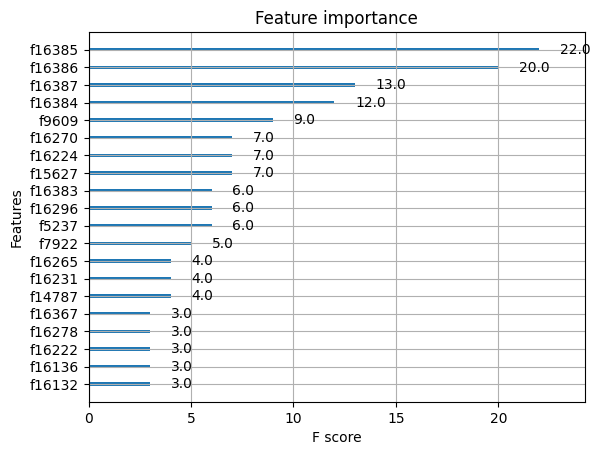

In [24]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Assume labels are already encoded as 0,1,2

# Initialize model
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    n_estimators=100,
    eval_metric='mlogloss',
    early_stopping_rounds=20
)

xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Predict
y_pred = xgb_clf.predict(X_test)

# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# # Save the model
# import joblib
# joblib.dump(xgb_clf, "results/xgboost_model.pkl")

# Plot feature importance
xgb.plot_importance(xgb_clf, max_num_features=20)
plt.show()
